In [19]:

# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import joblib

In [3]:
# Read the CSV file with latin1 encoding
r_data = pd.read_csv(r'C:\Users\parth.parikh1\Downloads\Data_2.csv', encoding='latin1')

# Specify the path for the output CSV file with UTF-8 encoding
output_file_path = r'C:\Users\parth.parikh1\Downloads\Data_2_utf8.csv'

# Convert the dataframe to CSV with UTF-8 encoding
r_data.to_csv(output_file_path, encoding='utf-8', index=False)

print(f"CSV file converted to UTF-8 encoding and saved to {output_file_path}.")

CSV file converted to UTF-8 encoding and saved to C:\Users\parth.parikh1\Downloads\Data_2_utf8.csv.


In [2]:
# Function for text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", " ", text)
    text = re.sub(r"\b(?:\d{3}[-.\s]??\d{3}[-.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-.\s]??\d{4}|\d{3}[-.\s]??\d{4})\b", " ", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [5]:
# Load and preprocess data
resume_data = pd.read_csv(r'C:\Users\parth.parikh1\Downloads\Data_2_utf8.csv')
resume_data['preprocessed_text'] = resume_data['Resume'].apply(preprocess_text)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    resume_data['preprocessed_text'], resume_data['Category'], 
    test_size=0.2, random_state=42, stratify=resume_data['Category'])

In [7]:
# Encode labels for both training and testing data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
# Define the NMF pipeline
tfidf_vectorizer = TfidfVectorizer()
nmf_model = NMF(n_components=100)
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('nmf', nmf_model)
])

# Feature extraction with NMF using only training data
train_embeddings = pipeline.fit_transform(X_train)


In [9]:
# Undersampling to balance class distribution
undersampler = RandomUnderSampler(random_state=42)
train_embeddings_resampled, y_train_resampled = undersampler.fit_resample(train_embeddings, y_train_encoded)

# Train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(train_embeddings_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [10]:
# Transform testing data using the NMF pipeline
test_embeddings = pipeline.transform(X_test)

# Make predictions
predictions = classifier.predict(test_embeddings)

In [11]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_encoded, predictions)
precision = precision_score(y_test_encoded, predictions, average='weighted')
recall = recall_score(y_test_encoded, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9441624365482234
Precision: 0.966497461928934
Recall: 0.9441624365482234


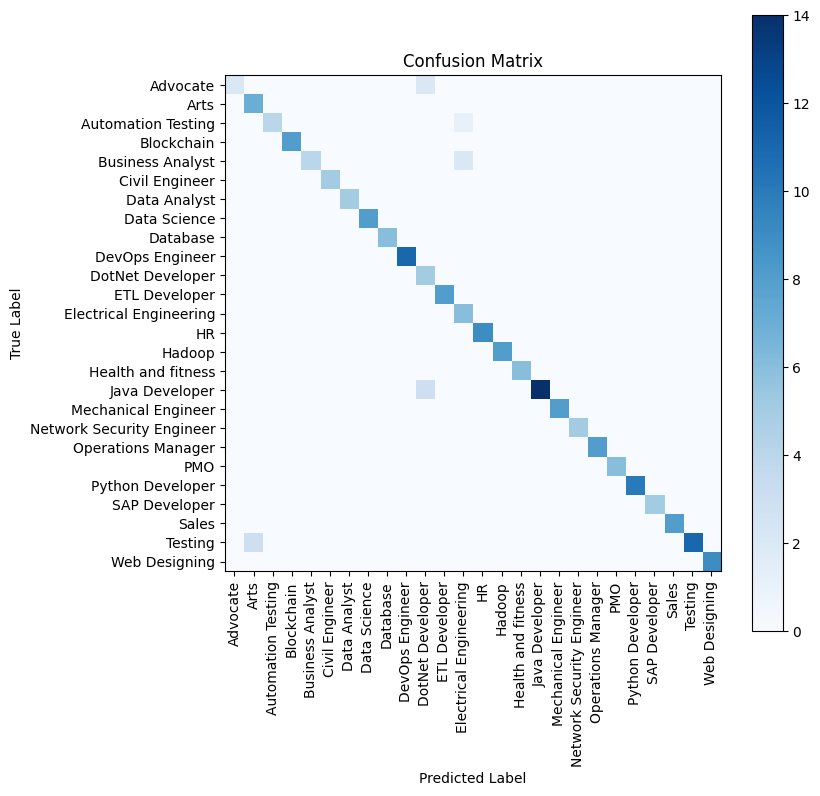

In [16]:


# Calculate confusion matrix
cm = confusion_matrix(y_test_encoded, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
plt.yticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

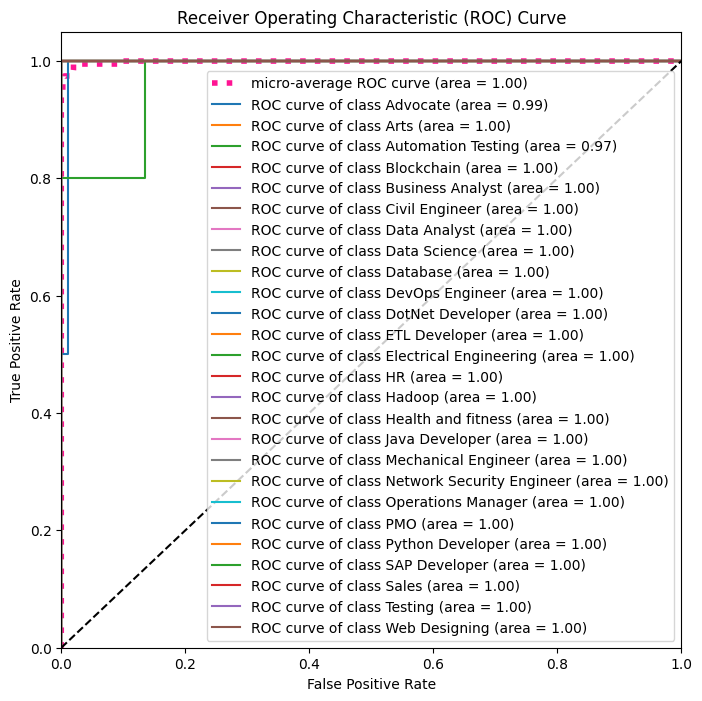

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# Convert labels to binary format
y_test_binary = label_binarize(y_test_encoded, classes=np.unique(y_test_encoded))

# Use OneVsRestClassifier for multiclass ROC curve
classifier_ovr = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
classifier_ovr.fit(train_embeddings_resampled, y_train_resampled)

# Get decision function scores
y_score = classifier_ovr.predict_proba(test_embeddings)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [20]:
joblib.dump(classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [21]:
# Fit the TF-IDF vectorizer with your training data
tfidf_vectorizer.fit(X_train)

# Save the fitted TF-IDF vectorizer to a file
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [24]:
# Save the fitted NMF model
joblib.dump(nmf_model, 'nmf_model.pkl')

['nmf_model.pkl']

In [25]:
# Save the label encoder object to a file
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']